In [61]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [62]:
network = 'tarbase'

file_path_1 = f'./output/{network}_om.z_1000.tsv'
file_path_2 = f'./output/{network}_pm.z_1000.tsv'

df_1 = pd.read_csv(file_path_1, sep='\t', header=0)
df_2 = pd.read_csv(file_path_2, sep='\t', header=0)

In [63]:
mirna_origin_file_path = '../../MirGeneDB_miRNA_origin/hsa_mirgenedb3.0_to_everything.mirna_origin.tsv'
df_mirna_origin = pd.read_csv(mirna_origin_file_path, sep='\t', header=None)
# keep only columns 8,14,15 and remove duplicates
df_mirna_origin = df_mirna_origin[[8, 14, 15]]
df_mirna_origin = df_mirna_origin.drop_duplicates()
cols = ["miRNA", "locus_node_of_origin", "family_node_of_origin"]
df_mirna_origin.columns = cols
df_mirna_origin

mirna_lno_dict = {}
for index, row in df_mirna_origin.iterrows():
	mirna = row['miRNA']
	lno = row['family_node_of_origin']
	if mirna not in mirna_lno_dict:
		mirna_lno_dict[mirna] = []
	mirna_lno_dict[mirna].append(lno)

mirna_lno_dict['MIRLET7E'][0]

'Bilateria'

In [64]:
df_wgd = df_1
df_ssd = df_2

In [65]:
print("Number of WGD pairs: ", len(df_wgd))
print("Number of SSD pairs: ", len(df_ssd))

Number of WGD pairs:  113
Number of SSD pairs:  1383


In [66]:
pre_2R_clades = ['Bilateria', 'Chordata', 'Eumetazoa', 'Vertebrata', 'Nephrozoa', 'Olphactores']

def all_clades_in_pre2R(mirna):
    clades = mirna_lno_dict.get(mirna, [])
    return all(clade in pre_2R_clades for clade in clades)

df_ssd = df_ssd[
    ~(
        df_ssd["miRNA_1"].apply(all_clades_in_pre2R) &
        df_ssd["miRNA_2"].apply(all_clades_in_pre2R)
    )
]

print("Number of WGD pairs: ", len(df_wgd))
print("Number of SSD pairs: ", len(df_ssd))

Number of WGD pairs:  113
Number of SSD pairs:  417


In [67]:
def remove_mirna_pairs(df1, df2):
	"""
	Removes from df1 all rows whose (miRNA_1, miRNA_2) pairs (regardless of order)
	are present in df2.
	"""
	# Create a set of tuples for the miRNA pairs in df2
	mirna_pairs = set()
	for _, row in df2.iterrows():
		mirna1 = row['miRNA_1']
		mirna2 = row['miRNA_2']
		if mirna1 != mirna2:
			mirna_pairs.add(tuple(sorted([mirna1, mirna2])))

	# Filter df1 to remove rows with miRNA pairs present in df2
	filtered_df = df1[~df1.apply(lambda row: tuple(sorted([row['miRNA_1'], row['miRNA_2']])) in mirna_pairs, axis=1)]
	
	return filtered_df


df_ssd = remove_mirna_pairs(df_ssd, df_wgd)

In [68]:
print("Number of WGD pairs after removing miRNA pairs from SSD: ", len(df_wgd))
print("Number of SSD pairs after removing miRNA pairs from SSD: ", len(df_ssd))

Number of WGD pairs after removing miRNA pairs from SSD:  113
Number of SSD pairs after removing miRNA pairs from SSD:  402


In [69]:
# if the column Z-score is equal to "sigma_err" and the column "n_relevant_bifan" is equal to 0, then the Z-score is equal to 0
def remove_sigma_err(df):
    # Step 1: Set Z-score to 0 if Z-score == 'sigma_err' and n_relevant_bifan == 0
    mask_fix = (df['Z-score'] == 'sigma_err') & (df['n_vmotif'] == 0)
    df.loc[mask_fix, 'Z-score'] = 0

    # Step 2: Remove rows where Z-score == 'sigma_err' and n_relevant_bifan != 0
    mask_remove = (df['Z-score'] == 'sigma_err') & (df['n_vmotif'] != 0)
    df = df[~mask_remove]

    return df

df_wgd = remove_sigma_err(df_wgd)
df_ssd = remove_sigma_err(df_ssd)

In [70]:
df_wgd_zscores = df_wgd['Z-score'].astype(float)
df_ssd_zscores = df_ssd['Z-score'].astype(float)

In [71]:
df_wgd_nbifan = df_wgd['n_vmotif'].astype(int)
df_ssd_nbifan = df_ssd['n_vmotif'].astype(int)

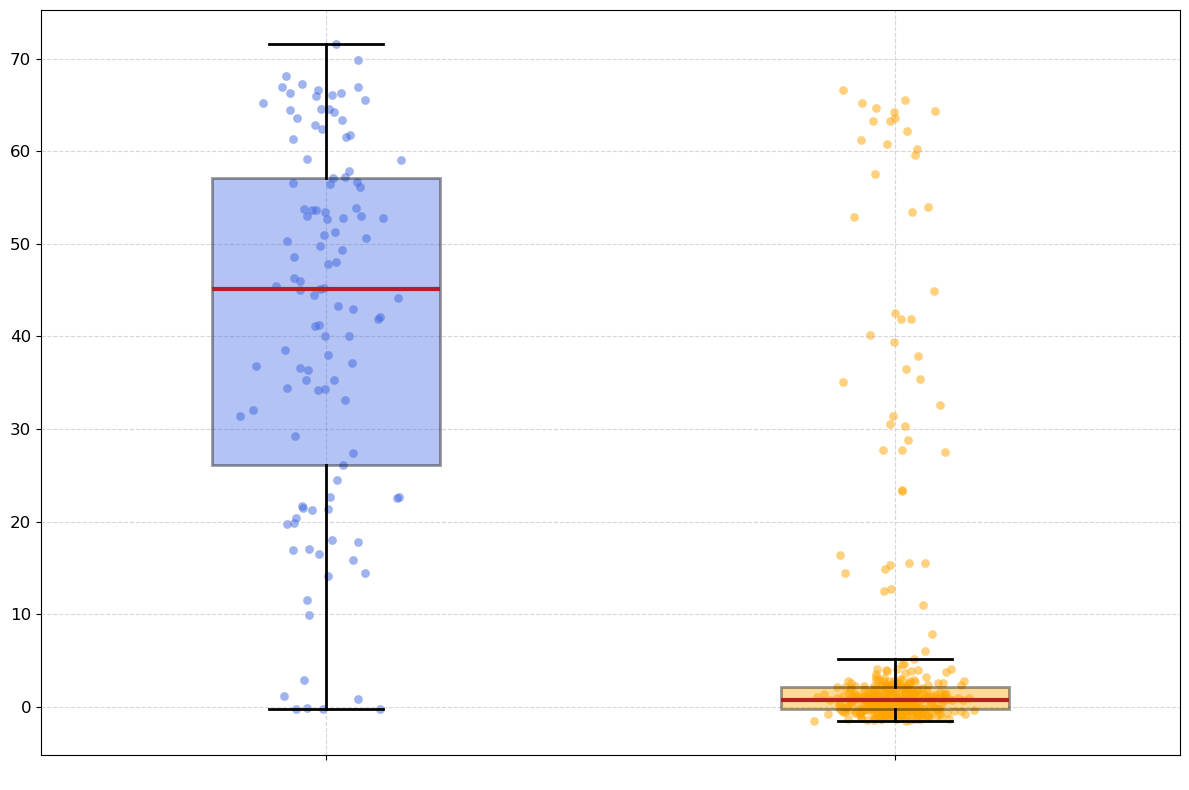

In [73]:
data = [df_wgd_zscores, df_ssd_zscores]
positions = [0, 1]
colors = ['royalblue', 'orange']

plt.figure(figsize=(12, 8))

box = plt.boxplot(data, 
                  positions=positions, 
                  widths=0.4,
                  patch_artist=True, 
                  showfliers=False)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')
    patch.set_linewidth(2)
    patch.set_alpha(0.4)
    
for element in ['whiskers', 'caps']:
    for line in box[element]:
        line.set_linewidth(2)
        line.set_color('black')
        
for element in ['medians']:
    for line in box[element]:
        line.set_linewidth(3)
        line.set_color('firebrick')

for i, (scores, color) in enumerate(zip(data, colors)):
    jittered_x = np.random.normal(loc=positions[i], scale=0.05, size=len(scores))
    plt.scatter(jittered_x, scores, alpha=0.5, color=color, linewidth=0.2, label=['', ''][i])

plt.xticks(positions, [' ', ' '], fontsize=100)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.savefig(f'../../local/pictures/{network}_vmotif_boxplot_zscores_mgdbSSD.png', dpi=300)
plt.show()

In [ ]:
ks_stat, ks_p_value = stats.ks_2samp(df_wgd_zscores, df_ssd_zscores)
print(f"KS statistic: {ks_stat}, p-value: {ks_p_value}")

KS statistic: 0.8199626450838262, p-value: 1.5213094710608742e-61


In [ ]:
# print the SSD pairs with Z-score > 3
df_ssd_high_z = df_ssd[df_ssd['Z-score'].astype(float) > 1]
df_ssd_high_z

,miRNA_1,miRNA_2,n_tar_1,n_tar_2,n_common_targets,mu,sigma,n_vmotif,n_maj_true,Z-score,pValue (nm size=1000)
60,MIR1185-1,MIR1185-2,63,63,63,1.014,1.029468,63,0,60.2116924628103,0.0
62,MIR1185-1,MIR299,63,105,3,1.627,1.259314,3,214,1.0902763924817964,0.1377957055458061
77,MIR1185-1,MIR494,63,54,2,0.895,0.934866,2,221,1.1819871989066735,0.11860539010788962
84,MIR1185-2,MIR299,63,105,3,1.653,1.256420,3,234,1.0720938001036715,0.14183895165429727
99,MIR1185-2,MIR494,63,54,2,0.866,0.894452,2,212,1.2678156787905936,0.10243189086732207
...,...,...,...,...,...,...,...,...,...,...,...
1306,MIR550A2,MIR550A3,123,94,63,3.004,1.709966,63,0,35.08607606189741,0.0
1307,MIR550A2,MIR550B1,123,123,123,3.756,1.854849,123,0,64.28772050207175,0.0
1308,MIR550A3,MIR550B1,94,123,63,2.959,1.647216,63,0,36.449996331172734,0.0
1309,MIR550A3,MIR550B2,94,123,63,2.878,1.585912,63,0,37.910054542243834,0.0


In [ ]:
df_wgd_high_z = df_wgd[df_wgd['Z-score'].astype(float) > 3]
df_wgd_high_z

,miRNA_1,miRNA_2,n_tar_1,n_tar_2,n_common_targets,mu,sigma,n_vmotif,n_maj_true,Z-score,pValue (nm size=1000)
0,MIR101-1,MIR101-2,190,159,159,7.334,2.472740,159,0,61.335195,0.0
1,MIR103A1,MIR103A2,950,1075,950,192.885,11.318117,950,0,66.894077,0.0
2,MIR103A1,MIR107,950,959,927,174.186,11.057640,927,0,68.080892,0.0
3,MIR103A2,MIR107,1075,959,930,193.784,11.455625,930,0,64.266769,0.0
4,MIR106A,MIR106B,538,398,205,46.433,6.068403,205,0,26.129940,0.0
...,...,...,...,...,...,...,...,...,...,...,...
108,MIRLET7A2,MIRLET7E,926,355,262,68.171,7.077412,262,0,27.386989,0.0
109,MIRLET7C,MIRLET7E,328,355,247,26.765,4.886489,247,0,45.070192,0.0
110,MIRLET7D,MIRLET7G,614,620,215,79.724,7.923372,215,0,17.073034,0.0
111,MIRLET7D,MIRLET7I,614,478,202,62.692,7.012356,202,0,19.866077,0.0


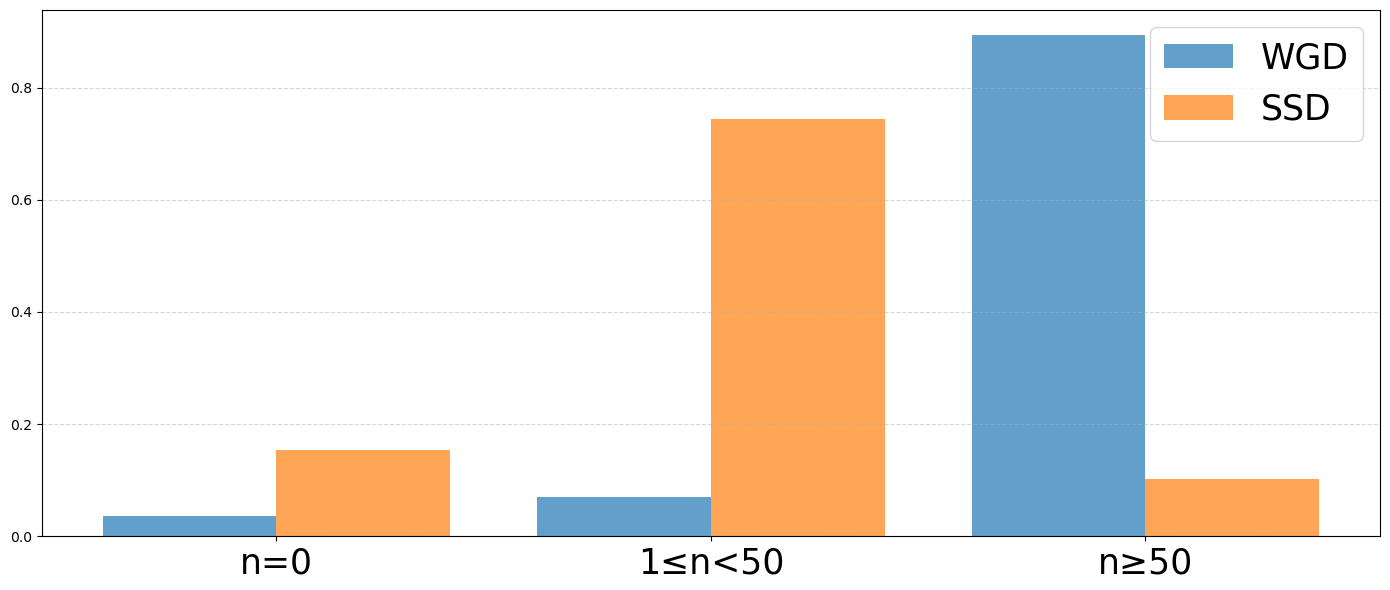

In [ ]:
labels = ['n=0', '1≤n<50', 'n≥50']

def bin_vmotif(count, labels=labels):
    if count == 0:
        return labels[0]
    if count >= 1 and count < 50:
        return labels[1]
    else:
        return labels[2]

wgd_binned = pd.Series(df_wgd_nbifan).apply(bin_vmotif)
ssd_binned = pd.Series(df_ssd_nbifan).apply(bin_vmotif)

wgd_freq = wgd_binned.value_counts(normalize=True).reindex(labels, fill_value=0)
ssd_freq = ssd_binned.value_counts(normalize=True).reindex(labels, fill_value=0)

x = np.arange(len(labels))
width = 0.4

plt.figure(figsize=(14, 6))
plt.bar(x - width/2, wgd_freq, width=width, label='WGD', alpha=0.7)
plt.bar(x + width/2, ssd_freq, width=width, label='SSD', alpha=0.7)

plt.xticks(x, labels, fontsize=25)
plt.xlabel('')
plt.title('')
plt.legend(fontsize=25, loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(f'../../local/pictures/{network}_vmotif_barplot_zscores_mgdbSSD.png', dpi=300)
plt.show()